# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from siamese_dataset import SiameseDataset
import os

## Helper functions
Set of helper functions to visualize data and training curves

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(train_losses, val_losses):
    
    x = list(range(len(train_losses)))
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('Train and Val Losses')
    ax1.plot(x, train_losses)
    ax2.plot(x, val_losses)
    plt.savefig('train_val_loss.png')
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "./address_gram_images/train/"
    val_dir = "./address_gram_images/val/"
    test_dir = "./address_gram_images/test/"
    
    train_batch_size = 64
    train_number_epochs = 60

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

## Using Image Folder Dataset

In [4]:
# create image folder objects
train_folder = dset.ImageFolder(root=Config.training_dir)
val_folder = dset.ImageFolder(root=Config.val_dir)
test_folder = dset.ImageFolder(root=Config.test_dir)

In [5]:
# define transforms
image_size = 128

transform_all = transforms.Compose([transforms.Resize((image_size, image_size)),
                                    transforms.ToTensor()] )  # can potentially change these vals

# create dataset objects

In [6]:
train_dataset = SiameseDataset(imageFolderDataset=train_folder,
                                        transform=transform_all,
                                       should_invert=False)
val_dataset = SiameseDataset(imageFolderDataset=val_folder,
                                        transform=transform_all,
                                       should_invert=False)
test_dataset = SiameseDataset(imageFolderDataset=test_folder,
                                        transform=transform_all,
                                       should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

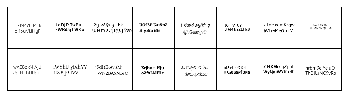

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [7]:
vis_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        image_size = 128
        fc_dropout_prob = 0.5
        
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
#             nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*32*32, 3000),  # flatten here
            nn.ReLU(inplace=True),
#             nn.Dropout(p=fc_dropout_prob),

#             nn.Linear(2000, 128),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=fc_dropout_prob),

            nn.Linear(3000, 500))  # change this output dimension later

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [12]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)
val_dataloader = DataLoader(val_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [13]:
net = SiameseNetwork()

if torch.cuda.is_available():
    net = SiameseNetwork().cuda()
    
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay=1e-5)

In [14]:
counter = []
loss_history = [] 
iteration_number= 0

# Save model dir here

In [15]:
# make saved_model root
saved_models_dir = './saved_models'
if not os.path.exists(saved_models_dir):
    os.mkdir(saved_models_dir)

# Start training loop

In [16]:
train_losses = []
val_losses = []
best_val_loss = None
saving_threshold = 1.01

for epoch in range(0, Config.train_number_epochs):
    
    train_running_batch_loss = 0
    val_running_batch_loss = 0
    
    # train loop
    net.train()  # put in train mode
    for batch_num, batch in enumerate(train_dataloader,0):
        img0, img1 , label = batch  # grab the data from batch

        # place on cuda if available
        if torch.cuda.is_available():
            img0, img1, label = img0.cuda(), img1.cuda() , label.cuda()
            
        optimizer.zero_grad()  # zero grad
        output1, output2 = net(img0, img1)  # forward prop
        train_loss = criterion(output1, output2, label) # calc loss
        train_running_batch_loss += train_loss.item()  # add to running loss
        train_loss.backward()  # backprop
        optimizer.step()  # take step forward

        if batch_num % 20 == 0 :
            print("Epoch {}, step {}/{}, loss {:.3f}".format(epoch, batch_num, len(train_dataloader), train_loss.item()))
            if img0.shape[0] != Config.train_batch_size:
                print('different batch size {}, {}'.format(Config.train_batch_size, img0.shape[0]))
    
    # append avg loss for the epoch
    train_losses.append( train_running_batch_loss / len(train_dataloader) )
        
    # start val loop
    net.eval()  # put in eval mode
    with torch.no_grad():  # turn off gradient tracking
        for batch_num, batch in enumerate(val_dataloader, 0):
            img0, img1, label = batch  # grab the data

            # place on cuda if available
            if torch.cuda.is_available():
                img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
                
            output1, output2 = net(img0, img1)  # forward prop
            val_loss = criterion(output1, output2, label) # calc loss
            val_running_batch_loss += val_loss.item()

    # append avg loss for the epoch      
    val_losses.append( val_running_batch_loss / len(val_dataloader) )

    # if model improves save
    if best_val_loss is None or best_val_loss > (saving_threshold * val_losses[-1]):
        print("Model improved...saving")
        
        model_name = '{}.pth'.format(str(val_losses[-1]))
        save_path = os.path.join(saved_models_dir, model_name)
        torch.save(net.state_dict(), save_path)
        best_val_loss = val_losses[-1]
                    
    # print stats on epoch (print the last value appended)
    print('Epoch {}/{}, train loss {:.3f}, val loss {:.3f}'.format(epoch, Config.train_number_epochs, train_losses[-1], val_losses[-1]))

Epoch 0, step 0/63, loss 1.986
Epoch 0, step 20/63, loss 0.612
Epoch 0, step 40/63, loss 0.710
Epoch 0, step 60/63, loss 0.404
Model improved...saving
Epoch 0/60, train loss 0.649, val loss 0.523
Epoch 1, step 0/63, loss 0.500
Epoch 1, step 20/63, loss 0.465
Epoch 1, step 40/63, loss 0.365
Epoch 1, step 60/63, loss 0.380
Model improved...saving
Epoch 1/60, train loss 0.415, val loss 0.474
Epoch 2, step 0/63, loss 0.548
Epoch 2, step 20/63, loss 0.330
Epoch 2, step 40/63, loss 0.251
Epoch 2, step 60/63, loss 0.482
Model improved...saving
Epoch 2/60, train loss 0.343, val loss 0.438
Epoch 3, step 0/63, loss 0.401
Epoch 3, step 20/63, loss 0.378
Epoch 3, step 40/63, loss 0.284
Epoch 3, step 60/63, loss 0.229
Model improved...saving
Epoch 3/60, train loss 0.306, val loss 0.394
Epoch 4, step 0/63, loss 0.226
Epoch 4, step 20/63, loss 0.235
Epoch 4, step 40/63, loss 0.239
Epoch 4, step 60/63, loss 0.205
Epoch 4/60, train loss 0.265, val loss 0.399
Epoch 5, step 0/63, loss 0.258
Epoch 5, step

Traceback (most recent call last):
  File "/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + 

KeyboardInterrupt: 

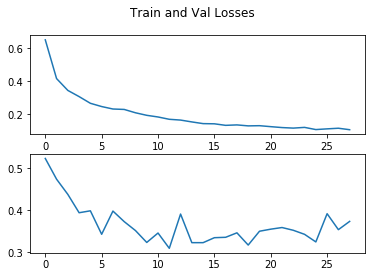

In [17]:
# plot train/val loss
show_plot(train_losses, val_losses)

# Load weights

In [10]:
train_net = SiameseNetwork()

In [11]:
PATH = './saved_models/0.3092366782948375.pth'

In [12]:
train_net.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Display a batch with similarity score

tensor([[1.]])


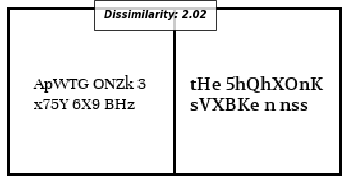

tensor([[1.]])


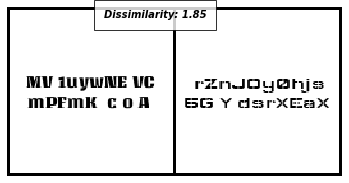

tensor([[1.]])


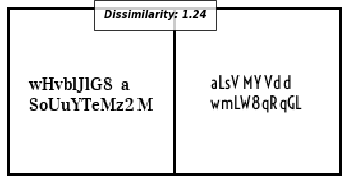

tensor([[1.]])


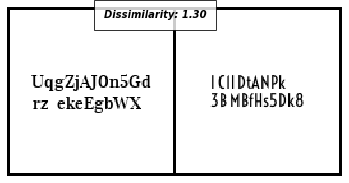

tensor([[1.]])


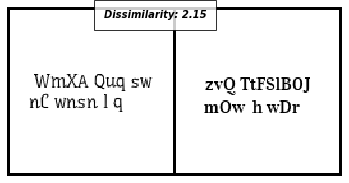

tensor([[1.]])


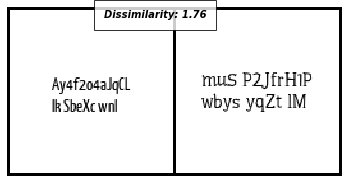

tensor([[0.]])


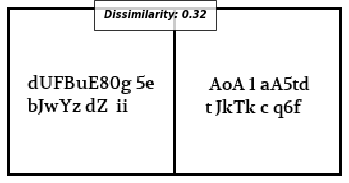

tensor([[0.]])


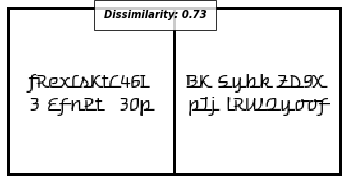

tensor([[0.]])


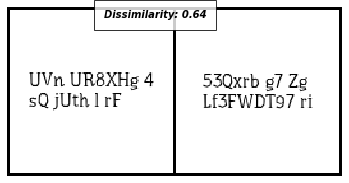

tensor([[1.]])


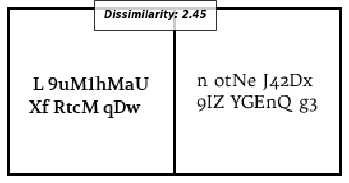

In [61]:
display_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

for i in range(10):
    x0,x1,label2 = next(iter(display_dataloader))
    concatenated = torch.cat((x0,x1),0)
    
    if torch.cuda.is_available():
        output1,output2 = train_net(Variable(x0).cuda(),Variable(x1).cuda())
    else:
        output1,output2 = train_net(Variable(x0),Variable(x1))
    
    print(label2)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

# Evaluate on test data

In [88]:
# set threshold for true and false matches (over this value is false)
threshold = 0.94
batch_size = 64
true_accs = []
false_accs = []

test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=batch_size, shuffle=True)

for batch_num, batch in enumerate(test_dataloader):

    # track number correct for each class
    true_correct = 0
    false_correct = 0
    
    false_wrong = 0
    true_wrong = 0
    
    # retrieve batch data
    x0, x1, labels = batch
    
    if torch.cuda.is_available():
        output0, output1 = train_net(Variable(x0).cuda(),Variable(x1).cuda())
    else:
        output0, output1 = train_net(Variable(x0),Variable(x1))
        
    euclidean_distance = F.pairwise_distance(output0, output1)
    
    # create an array of size batch, of threshold
    thresh_array = np.asarray(euclidean_distance.shape[0] * [threshold])
    
    # check if over threshold
#     pred_bools = np.less(euclidean_distance.data.cpu().numpy(), thresh_array)
    
    # calc counts for each class
    false_count = 0
    true_count =  0
    
#     print('false {} and true {} counts'.format(false_count, true_count))
    
    preds = []

    for j in range(euclidean_distance.shape[0]):

        if euclidean_distance[j] < threshold:
            preds.append(0)
        else:
            preds.append(1)

#     print('len preds', len(preds))
    
    # loop thru all labels 
    for i in range(labels.shape[0]):
        
        label = int(labels[i].item())
        pred = preds[i]

        # track false match predictions
        if label == 1:
            false_count += 1
            # if pred is false, and label is false, add 1
            if pred == label:
                false_correct += 1
#                 print('pred == label!!  and label is 1')
            else:
                false_wrong += 1
        # false match
        else:
            true_count += 1
            # if pred is true, and label is true, add 1
            if pred == label:
                true_correct += 1
#                 print('pred == label!!  and label is 0')

            else:
                true_wrong += 1
                
#     print('true correct count', true_correct)
#     print('true wrong count', true_wrong)
#     print('true count total', true_count)

#     print('false correct count', false_correct)
#     print('false wrong count', false_wrong)
#     print('false count total', false_count)
                
    true_match_acc = (true_correct / true_count)*100 
    false_match_acc = (false_correct / false_count)*100
        
    print('Similar font accuracy {:.2f}%'.format(true_match_acc))
    print('Different font accuracy {:.2f}%'.format(false_match_acc))
            
    # append acc for this batch
    true_accs.append(true_match_acc)
    false_accs.append(false_match_acc)
    

Similar font accuracy 86.67%
Different font accuracy 94.12%
Similar font accuracy 90.32%
Different font accuracy 75.76%
Similar font accuracy 76.67%
Different font accuracy 97.06%
Similar font accuracy 86.49%
Different font accuracy 85.19%
Similar font accuracy 75.68%
Different font accuracy 92.59%
Similar font accuracy 82.76%
Different font accuracy 82.86%
Similar font accuracy 81.82%
Different font accuracy 83.87%
Similar font accuracy 93.10%
Different font accuracy 91.43%
Similar font accuracy 89.29%
Different font accuracy 91.67%
Similar font accuracy 78.12%
Different font accuracy 96.88%
Similar font accuracy 83.33%
Different font accuracy 94.12%
Similar font accuracy 81.08%
Different font accuracy 96.30%
Similar font accuracy 71.88%
Different font accuracy 93.75%
Similar font accuracy 88.89%
Different font accuracy 89.29%
Similar font accuracy 80.65%
Different font accuracy 93.94%
Similar font accuracy 81.25%
Different font accuracy 78.12%
Similar font accuracy 83.33%
Different f

In [92]:
avg_true_acc = sum(true_accs) / len(true_accs)
print(avg_true_acc)

82.96036982685344


In [93]:
avg_false_acc = sum(false_accs) / len(false_accs)
print(avg_false_acc)

89.10660825993288


In [94]:
overall = (avg_true_acc + avg_false_acc) / 2

In [95]:
overall

86.03348904339316